In [1]:
import pandas as pd
import numpy as np
from numpy import array
import re
import pickle
from pickle import dump, load
from time import time
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, load_model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from jiwer import wer

Using TensorFlow backend.


# CROPING IMAGES

In [ ]:
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [ ]:
file = open('dataset/im2latex_validate.lst', 'r')
doc = file.read()
#print(doc)

for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    image_id= tokens[1]
    image_path = "dataset/formula_images/" + image_id + ".png"
    image_path1 = "dataset/formula_images1/" + image_id + ".png"
    im = Image.open(image_path)
    im = trim(im)
    try:
        width, height = im.size 
        im1 = im.crop((0,0,width,height))
        im1.save(image_path1)
    except AttributeError:
        print(image_id)
        continue
file.close()
print("done")

# REMOVING EMPTY IMGAES

In [2]:
with open('dataset/im2latex_test.lst', "r") as input:
    with open('dataset/wrong_test.lst', "r") as test: 
        with open('dataset/test.lst', 'w') as output: 
            x = False
            doc = test.read()
            token = doc.split()
            
            for line in input:
                token1 = line.split()
                image = token1[1]
                for wrong in token: 
                    if image == wrong:
                        x = True
                        break
                if x == True:
                    x = False
                    continue
                else:
                    output.write(line)
print("done")

done


# CLEARING LATEX FORMULAS

In [2]:
with open('dataset/im2latex_formulas.lst', 'r', encoding = "ISO-8859-1") as input:
    with open('dataset/formulas.lst', 'w', encoding = "ISO-8859-1") as output:
        i = 0
        toolong = list()
        for lines in input:
            lines = re.sub('label\{.*?\}', 'label',lines)
            lines = lines.replace('\\label', ' ')
            lines = re.sub(r'(\\begin{array}|\\end{array}|\\\W|\\[^\W_^\d]*|.)', r'\1 ' ,lines)
            lines = re.sub('	+', ' ',lines)
            lines = re.sub(' +', ' ',lines)
            if len(lines.split()) > 40:
                toolong.append(i)
            i += 1
            output.write(lines)
print(len(toolong))
print("done")

64242
done


# SET OF WORDS

In [3]:
descriptions = dict()
desc_train = {}
desc_test = {}
desc_val = {}
train_list = ''
test_list = ''
val_list = ''

with open('dataset/formulas.lst', 'r', encoding = "ISO-8859-1") as formulas_file:
    with open('dataset/train.lst', 'r', encoding = "ISO-8859-1") as train_file:
        with open('dataset/val.lst', 'r', encoding = "ISO-8859-1") as val_file:
            with open('dataset/test.lst', 'r', encoding = "ISO-8859-1") as test_file:
                formulas_list = formulas_file.read()
                formulas_list = formulas_list.split('\n')
                train_list1 = train_file.read()
                val_list1 = val_file.read()
                test_list1 = test_file.read()
                for line in train_list1.split('\n'):
                    # split line by white space
                    tokens = line.split()
                    formula_id, image_id = tokens[0], tokens[1]
                    if int(formula_id) not in toolong:
                        formula = 'startseq ' + formulas_list[int(formula_id)] + 'endseq'
                        formula = lines = re.sub(' +', ' ',formula)
                        desc_train[image_id] = formula
                        descriptions[image_id] = formula
                        train_list = train_list + line + '\n'
                for line in val_list1.split('\n'):
                    # split line by white space
                    tokens = line.split()
                    formula_id, image_id = tokens[0], tokens[1]
                    if int(formula_id) not in toolong:
                        formula = 'startseq ' + formulas_list[int(formula_id)] + 'endseq'
                        formula = lines = re.sub(' +', ' ',formula)
                        desc_val[image_id] = formula
                        descriptions[image_id] = formula
                        val_list = val_list + line + '\n'
                for line in test_list1.split('\n'):
                    # split line by white space
                    tokens = line.split()
                    formula_id, image_id = tokens[0], tokens[1]
                    if int(formula_id) not in toolong:
                        formula = 'startseq ' + formulas_list[int(formula_id)] + 'endseq'
                        formula = lines = re.sub(' +', ' ',formula)
                        desc_test[image_id] = formula
                        descriptions[image_id] = formula
                        test_list = test_list + line + '\n'
                train_list = train_list[:-1]
                val_list = val_list[:-1]
                test_list = test_list[:-1]
print(len(desc_train))    

32284


In [4]:
vocabulary = set()
with open('dataset/formulas.lst', 'r', encoding = "ISO-8859-1") as input:
    doc = input.read()
    doc = doc.split()
    print('Symbols:',len(doc))
    for x in doc: 
        if x not in vocabulary: 
            vocabulary.add(x)
    vocabulary.add('startseq')
    vocabulary.add('endseq')
    print('Unique symbols:', len(vocabulary))

Symbols: 5990389
Unique symbols: 865


In [5]:
# Get the InceptionV3 model trained on imagenet data
model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [6]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [8]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
start = time()
encoding_train = {}
for line in train_list.split('\n'):
    token = line.split()
    img = 'dataset/formula_images1/'+token[1]+'.png'
    encoding_train[token[1]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
with open("dataset/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [9]:
start = time()
encoding_test = {}
for line in test_list.split('\n'):
    token = line.split()
    img = 'dataset/formula_images1/'+token[1]+'.png'
    encoding_test[token[1]] = encode(img)
print("Time taken in seconds =", time()-start)

/usr/lib/python3/dist-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
Time taken in seconds = 111.28281593322754


In [10]:
with open("dataset/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [11]:
start = time()
encoding_val = {}
for line in val_list.split('\n'):
    token = line.split()
    img = 'dataset/formula_images1/'+token[1]+'.png'
    encoding_val[token[1]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 97.12680506706238


In [12]:
with open("dataset/encoded_val_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle)

In [ ]:
start = time()
encoding_rlyval = {}
for i in range(1,51):
    img = 'dataset/val-test/val'+str(i)+'.png'
    encoding_rlyval[i] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
with open("dataset/encoded_rlyval_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_rlyval, encoded_pickle)

In [7]:
train_features = load(open("dataset/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=32284


In [8]:
val_features = load(open("dataset/encoded_val_images.pkl", "rb"))
print('Photos: val=%d' % len(val_features))

Photos: val=3570


In [9]:
test_features = load(open("dataset/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=3974


In [10]:
all_train_captions = list()

for key in train_features.keys():
    all_train_captions.append(descriptions[key])
    
len(all_train_captions)

32284

In [11]:
all_val_captions = list()

for key in val_features.keys():
    all_val_captions.append(descriptions[key])
    
len(all_val_captions)

3570

In [12]:
desc_train = dict()
for key in train_features.keys():
    desc_train[key] = descriptions[key]

len(desc_train)
#print(desc_train['10007a9101'])

32284

In [13]:
desc_val = dict()
for key in val_features.keys():
    desc_val[key] = descriptions[key]

len(desc_val)
#print(desc_train['10007a9101'])

3570

In [14]:
all_test_captions = list()

for key in test_features.keys():
    all_test_captions.append(descriptions[key])
    
len(all_test_captions)

3974

In [15]:
desc_test = dict()
for key in test_features.keys():
    desc_test[key] = descriptions[key]

len(desc_test)
#print(desc_train['10007a9101'])

3974

In [16]:
for key in train_features.keys():
    a = train_features[key]

In [17]:
ixtoword = {}
wordtoix = {}
ix = 0
for w in vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
print(len(wordtoix))

865


In [18]:
def max_length(descriptions):
    return max(len(descriptions[key].split()) for key in descriptions.keys())
# determine the maximum sequence length
max_length = max_length(descriptions)
print('Max Description Length: %d' % max_length)

Max Description Length: 42


In [19]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open('dataset/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [20]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((len(wordtoix), embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(865, 200)

# MODEL

In [55]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(1024, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(len(wordtoix), max_length, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(1024, activation='relu')(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(1024, activation='relu')(decoder1)
outputs = Dense(len(wordtoix), activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [50]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(1024, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(len(wordtoix), embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(1024, activation='relu')(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(1024, activation='relu')(decoder1)
outputs = Dense(len(wordtoix), activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [56]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 42)           0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 42, 42)       36330       input_35[0][0]                   
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 2048)         0           input_34[0][0]                   
____________________________________________________________________________________________

In [67]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [57]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:

# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list.split('\n'):
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split() if word in wordtoix]
                #print(seq)
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    #print(in_seq)
                    #print(out_seq)
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=len(wordtoix))[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

# NOT FROM GUIDE

In [58]:
import datetime
number_pics_per_bath = 3
steps = len(train_features)//number_pics_per_bath
generatorTrain = data_generator(desc_train, train_features, wordtoix, max_length, number_pics_per_bath)
generatorVal = data_generator(desc_val, val_features, wordtoix, max_length, number_pics_per_bath)
history = model.fit_generator(generatorTrain, epochs=20, steps_per_epoch=steps, verbose=1, validation_data=generatorVal, validation_steps=len(desc_val))
model.save_weights('model_weights/model_new_weights' + datetime.datetime.now() +'.h5')

/home/fcek/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Epoch 1/20
  100/10761 [..............................] - ETA: 15:10 - loss: 5.2757 - accuracy: 0.0875

KeyboardInterrupt: 

In [0]:
history_dict = history.history
print(history_dict.keys())
print(history.history['loss'])

In [0]:
number_pics_per_bath = 3
step = len(test_features)//number_pics_per_bath
generatorTest = data_generator(desc_test, test_features, wordtoix, max_length, number_pics_per_bath)
results = model.evaluate_generator(generatorTest, steps=step, verbose=1)
print('test loss, test acc:', results)

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

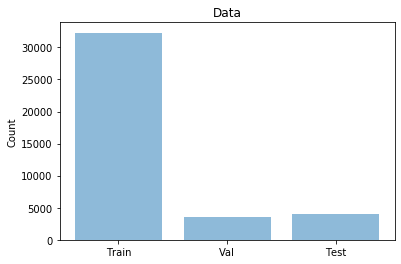

In [84]:
objects = ('Train', 'Val', 'Test')
y_pos = np.arange(len(objects))
count = [len(train_features),len(val_features),len(test_features)]
plt.bar(y_pos, count, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Data')
plt.ylabel('Count')
plt.show()

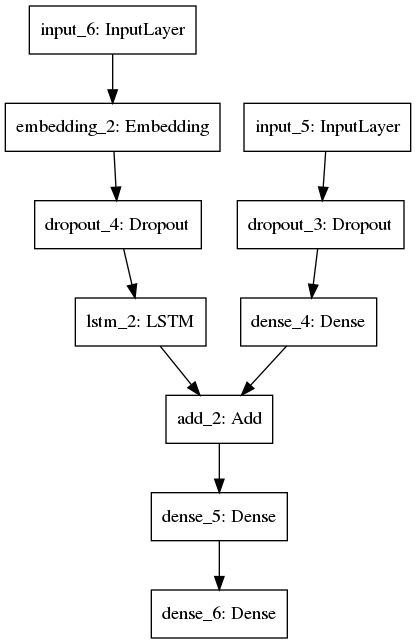

In [79]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

# GUIDE

In [20]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_features)//number_pics_per_bath
#print(len(train_features['10007a9101']))

In [21]:
for i in range(epochs):
    generator = data_generator(desc_train, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_weights/model_' + str(i) + '.h5')

Epoch 1/1
10761/10761 [==============================] - 363s 34ms/step - loss: 3.0887
Epoch 1/1
10761/10761 [==============================] - 361s 34ms/step - loss: 2.8339
Epoch 1/1
10761/10761 [==============================] - 337s 31ms/step - loss: 2.7632
Epoch 1/1
10761/10761 [==============================] - 326s 30ms/step - loss: 2.7234
Epoch 1/1
10761/10761 [==============================] - 349s 32ms/step - loss: 2.6963
Epoch 1/1
10761/10761 [==============================] - 381s 35ms/step - loss: 2.6766
Epoch 1/1
10761/10761 [==============================] - 370s 34ms/step - loss: 2.6620
Epoch 1/1
10761/10761 [==============================] - 370s 34ms/step - loss: 2.6496
Epoch 1/1
10761/10761 [==============================] - 354s 33ms/step - loss: 2.6400
Epoch 1/1
10761/10761 [==============================] - 343s 32ms/step - loss: 2.6325


In [22]:

for i in range(epochs):
    generator = data_generator(desc_train, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_weights/model_' + str(i+10) + '.h5')

Epoch 1/1
10761/10761 [==============================] - 377s 35ms/step - loss: 2.6255
Epoch 1/1
10761/10761 [==============================] - 418s 39ms/step - loss: 2.6202
Epoch 1/1
10761/10761 [==============================] - 356s 33ms/step - loss: 2.6160
Epoch 1/1
10761/10761 [==============================] - 335s 31ms/step - loss: 2.6118
Epoch 1/1
10761/10761 [==============================] - 351s 33ms/step - loss: 2.6078
Epoch 1/1
10761/10761 [==============================] - 346s 32ms/step - loss: 2.6054
Epoch 1/1
10761/10761 [==============================] - 353s 33ms/step - loss: 2.6031
Epoch 1/1
10761/10761 [==============================] - 378s 35ms/step - loss: 2.6004
Epoch 1/1
10761/10761 [==============================] - 376s 35ms/step - loss: 2.5996
Epoch 1/1
10761/10761 [==============================] - 366s 34ms/step - loss: 2.5969


In [85]:
model.optimizer.learning_rate = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_features)//number_pics_per_bath

In [36]:
model.load_weights('model_weights/model_19.h5')

In [86]:
for i in range(epochs):
    generator = data_generator(desc_train, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_2' + str(i) + '.h5')

In [0]:
model.save('model_weights/model.h5')
model.save_weights('model_weights/model_weights.h5')

In [24]:
model.load_weights('model_weights/model_new_weights_40.h5')
#new_model = load_model('model_weights/model_30.h5')

In [25]:
with open("dataset/encoded_rlyval_images.pkl", "rb") as encoded_pickle:
    encoding_val = load(encoded_pickle)

In [26]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length-2):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

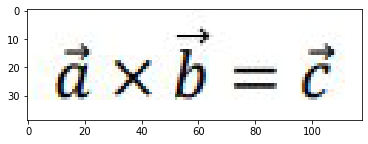

Greedy: \eqnum \vr \twomat \protect \matrix \eqnum \ddagger \lra \protect \lbrack \rho \matrix \ddagger \Gc \matrix \ddagger \Proj \rho \matrix \ddagger \Gc \matrix \ddagger \Proj \ddagger \Gc \matrix \ddagger \rho \matrix \ddagger \footnote \matrix \lra \footnote \matrix \ddagger \footnote \matrix


In [29]:
pic = list(encoding_val.keys())[4]
image = encoding_val[pic].reshape((1,2048))
x=plt.imread('dataset/val-test/val'+str(pic)+'.png')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

# Word Error Rate

In [28]:
error = list()
avg = 0
with open('dataset/val-test/valTex.txt') as file:
    formulas = file.read()
    formulas = formulas.split('\n')
for key in encoding_val.keys():
    image = encoding_val[pic].reshape((1,2048))
    err = wer(greedySearch(image), formulas[key-1])
    error.append(err)
    avg = avg + err
avg = avg/50
print(avg)

1.0
